In [22]:
import json
import bz2
import re
from tqdm import tqdm
from scipy import sparse

In [23]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Подключим Google Drive.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Colab Notebooks/003'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Функции, которые помогут отслеживать память и сохранять промежуточные значения, чтобы не допустить превышения лимитов.

In [25]:
import inspect
import pickle
import os
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def show_memory_usage(objs=locals().items()):
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in objs), key=lambda x: -x[1])[:10]:
        if name[0] != '_' and name not in ['rcParams', 'rcParamsDefault', 'rcParamsOrig', 'sctypeNA']:
            print(f"{name:>30}: {sizeof_fmt(size):>8}")

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

In [ ]:
responses = []
with bz2.BZ2File(base_dir + '/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

save_pickle(responses, "responses.pickle")

201030it [02:17, 1458.21it/s]


saved "responses.pickle" (470.2 MiB).


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [ ]:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
df = pd.DataFrame(responses)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


Подготовим данные

In [ ]:
df['rating_grade'].dropna(inplace=True)
df['city'].fillna('Другой', inplace=True)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,Другой,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,Другой,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,Другой,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,Другой,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [ ]:
# clear memory
del responses

show_memory_usage()

                            df: 560.1 MiB


1. Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
from collections import Counter

cities = df['city'].tolist()     # тут, конечно, можно было использовать встроенные
banks = df['bank_name'].tolist() # средства pandas место Counter для подсчета кол-ва

cities_freq = Counter(cities)
banks_freq = Counter(banks)

frame = pd.DataFrame(cities_freq.most_common(), columns=['Город', 'Кол-во'])
frame

,Город,Кол-во
0,г. Москва,55354
1,Другой,15174
2,г. Санкт-Петербург,14342
3,г. Екатеринбург,2337
4,г. Новосибирск,2300
...,...,...
5819,"г. Москва, павелецкое отделение",1
5820,г. вся РФ,1
5821,г. Москва-Владимир,1
5822,г. СПб.,1


In [ ]:
frame = pd.DataFrame(banks_freq.most_common(), columns=['Банк', 'Кол-во'])
frame

,Банк,Кол-во
0,Сбербанк России,26327
1,Альфа-Банк,10224
2,ВТБ 24,8185
3,Русский Стандарт,7943
4,Хоум Кредит Банк,7549
...,...,...
665,Петровка,1
666,Алмазэргиэнбанк,1
667,Юникбанк,1
668,Витязь,1


In [ ]:
# clear memory
del cities
del banks
del cities_freq
del banks_freq
del frame

show_memory_usage()

                            df: 560.1 MiB


2. Постройте гистограмы длин слов в символах и в словах

Воспользуемся regexp токенайзером, чтобы сразу выкинуть пунктуацию.

In [ ]:
from nltk.tokenize import toktok, word_tokenize, RegexpTokenizer

def lower_words_only_tokenizer(text, tokenizer, tokens, tokens_full):
    tks = [token for token in tokenizer(text.lower())]
    tokens.append(tks)
    tokens_full += tks
    return " ".join(tks)

def drop_stop_words(text, stopwords, tokens, tokens_full):
    tks = [word for word in text.split() if word not in stopwords]
    tokens.append(tks)
    tokens_full += tks
    return " ".join(tks)

In [ ]:
nltk.download('punkt')

#tokenizer = toktok.ToktokTokenizer().tokenize
#tokenizer = word_tokenize
tokenizer = RegexpTokenizer(r'\w+').tokenize
tokens = []
corpus = []
df['text_mdf'] = df['text'].apply(lower_words_only_tokenizer, tokenizer=tokenizer, tokens=tokens, tokens_full=corpus)

len(corpus), len(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(37002810, 153499)

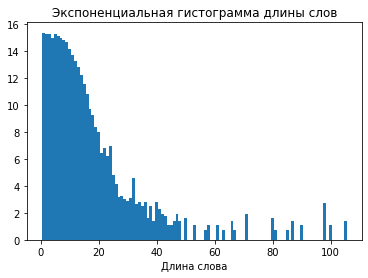

In [ ]:
lens = list(map(len, corpus))
lens_freq = Counter(lens)
mc = np.array(lens_freq.most_common())

plt.bar(mc[:,0], height=np.log(mc[:,1]), width=1)
plt.title("Экспоненциальная гистограмма длины слов")
plt.xlabel("Длина слова")
plt.show()

Какие-то странные слова получились с большой длиной. Посмотрим на них.

In [ ]:
words = []
for i in range(len(lens)):
    if lens[i] > 30:
        words.append(corpus[i])
    if len(words) == 10:
        break

for word in words:
    print(word)

po_initsiative_nagatinskoy_mezhrayonnoy_prokuratury_vozbuzhdeno_ugolovnoe_delo_o_moshennichestve_pri
ab2932e4423f0f3f740a4d6747fb7fb7
57af51f34d67a37027635ae36d516dbe
terms_of_integrated_banking_services
terms_of_integrated_banking_services
spravochnik_sms_uvedomlenij_22_10_14
b603c14a53b16359d0d1c6c85a16affd55a7dfae4bd3f2e8ccbc8dab193d6c4b08c9416996685386v6nen
b603c14a53b16359d0d1c6c85a16affd52a0dda84fd9afe2c4e581a91e32335c0f804d68966853v8n7n
b603c14a53b16359d0d1c6c85a16affd55a7dfae4bd3f2e8ccbc8dab193d6c4b08c9416996685387v6nfn
b603c14a53b16359d0d1cec64e7efaae59a1dbaa46daf0b5c6b4d4a71b3a63141fce0865976856876fvcnfnи


Похожи на какие-то детали транзакций. Не совсем ясно оставлять их или нет: с одной стороны - это не слова, с другой - есть повторения, а значит они могут быть использованы при построении тем. Оставим.

In [ ]:
# clear memory
del lens
del lens_freq
del mc

show_memory_usage()

                            df: 1009.5 MiB
                        corpus: 306.9 MiB
                        tokens:  1.3 MiB


3. Найдите 10 самых частых:  
а) слов

In [ ]:
words_freq = Counter(corpus)
frame = pd.DataFrame(words_freq.most_common(), columns=['Слово', 'Кол-во'])
frame

,Слово,Кол-во
0,в,1330103
1,и,1058934
2,не,852416
3,на,707784
4,что,640053
...,...,...
347043,терпиливое,1
347044,усачевой,1
347045,коммисий,1
347046,проясняются,1


б) слов без стоп-слов

In [ ]:
from nltk.corpus import stopwords

nltk.download('stopwords')
russian_stopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
tokens_wo_stops = []
corpus_wo_stops = []
df['text_mdf'] = df['text_mdf'].apply(drop_stop_words, stopwords=russian_stopwords, tokens=tokens_wo_stops, tokens_full=corpus_wo_stops)

len(corpus_wo_stops), len(tokens_wo_stops)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(23616136, 153499)

In [ ]:
words_freq_wo_stops = Counter(corpus_wo_stops)
frame = pd.DataFrame(words_freq_wo_stops.most_common(), columns=['Слово', 'Кол-во'])
frame

,Слово,Кол-во
0,банка,275765
1,банк,215209
2,деньги,131197
3,карту,105824
4,карты,101814
...,...,...
346884,терпиливое,1
346885,усачевой,1
346886,коммисий,1
346887,проясняются,1


In [ ]:
# clear memory
del corpus
del corpus_wo_stops
del words_freq
del tokens
del frame

show_memory_usage()

                            df:  1.6 GiB
           words_freq_wo_stops: 10.0 MiB
               tokens_wo_stops:  1.3 MiB


In [ ]:
save_pickle(df, "df_wo_stops.pickle")
save_pickle(words_freq_wo_stops, "words_freq_wo_stops.pickle")
save_pickle(tokens_wo_stops, "tokens_wo_stops.pickle")

saved "df_wo_stops.pickle" (769.2 MiB).
saved "words_freq_wo_stops.pickle" (9.3 MiB).
saved "tokens_wo_stops.pickle" (526.4 MiB).


в) лемм

In [ ]:
!pip install pymorphy2 >/dev/null

In [ ]:
from pymorphy2 import MorphAnalyzer # https://pymorphy2.readthedocs.io/en/0.2/user/index.html


def lemmatize_words(text, analyzer, lemmas, lemmas_nouns):
    lms = []
    tks = [word for word in text.split()]
    for word in tks:
        an = analyzer.parse(word)[0]
        lms.append(an.normal_form)
        if 'NOUN' in an.tag:
            lemmas_nouns.append(an.normal_form)
    lemmas += lms
    return " ".join(lms)


analyzer = MorphAnalyzer()
lemmas = []
lemmas_nouns = []
df['text_mdf'] = df['text_mdf'].apply(lemmatize_words, analyzer=analyzer, lemmas=lemmas, lemmas_nouns=lemmas_nouns)
len(lemmas)

23616136

In [ ]:
from collections import Counter

lemmas_freq = Counter(lemmas)
frame = pd.DataFrame(lemmas_freq.most_common(), columns=['Слово', 'Кол-во'])
frame

,Слово,Кол-во
0,банк,668070
1,карта,334980
2,деньга,179814
3,день,173578
4,мой,168990
...,...,...
171753,учытывать,1
171754,правдо,1
171755,касатться,1
171756,удостверенний,1


г) существительных

In [ ]:
len(lemmas_nouns)

10674783

In [ ]:
lemmas_nouns_freq = Counter(lemmas_nouns)
frame = pd.DataFrame(lemmas_nouns_freq.most_common(), columns=['Слово', 'Кол-во'])
frame

,Слово,Кол-во
0,банк,668070
1,карта,334980
2,деньга,179814
3,день,173578
4,кредит,156145
...,...,...
53815,сберка,1
53816,мерс,1
53817,170р,1
53818,нюанас,1


In [ ]:
save_pickle(lemmas, "lemmas.pickle")
save_pickle(lemmas_nouns, "lemmas_nouns.pickle")
save_pickle(words_freq_wo_stops, "words_freq_wo_stops.pickle")
save_pickle(lemmas_freq, "lemmas_freq.pickle")
save_pickle(df, "df_lemmas.pickle")
save_pickle(tokens_wo_stops, "tokens_wo_stops.pickle")

saved "lemmas.pickle" (516.7 MiB).
saved "lemmas_nouns.pickle" (230.6 MiB).
saved "words_freq_wo_stops.pickle" (9.3 MiB).
saved "lemmas_freq.pickle" (4.1 MiB).
saved "df_lemmas.pickle" (763.5 MiB).
saved "tokens_wo_stops.pickle" (526.4 MiB).


In [ ]:
# clear memory
del lemmas
del lemmas_nouns
del lemmas_nouns_freq
del frame

show_memory_usage()

                            df:  1.6 GiB
           words_freq_wo_stops: 10.0 MiB
                   lemmas_freq:  5.0 MiB
               tokens_wo_stops:  1.3 MiB


4. Постройте кривые Ципфа и Хипса

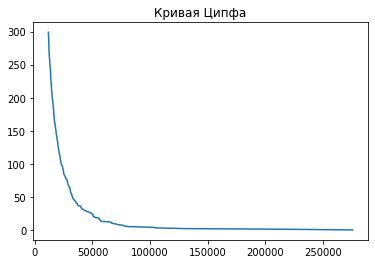

In [27]:
freqs = list(words_freq_wo_stops.values())
freqs = sorted(freqs, reverse=True)

plt.plot(freqs[:300], range(300))
plt.title("Кривая Ципфа")
plt.show()

In [28]:
cnt = Counter()
n_words = []
n_tokens = []
for tokens in tqdm(tokens_wo_stops):
    cnt.update(tokens)
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 153499/153499 [55:20<00:00, 46.22it/s]


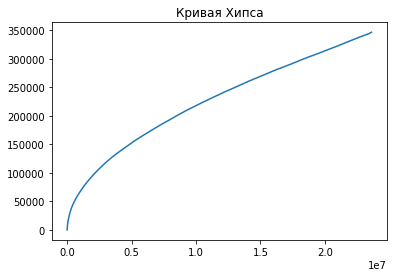

In [29]:
plt.plot(n_tokens, n_words)
plt.title("Кривая Хипса")
plt.show()

In [30]:
# clear memory
del words_freq_wo_stops
del freqs
del cnt
del n_words
del n_tokens
del tokens_wo_stops

show_memory_usage()

                            df: 917.8 MiB
                   lemmas_freq:  5.0 MiB
                       Subplot:  5.4 KiB


5. Ответьте на следующие вопросы:  
а) какое слово встречается чаще, "сотрудник" или "клиент"?


In [32]:
def more_often_word(freq, first, second):
    w1 = lemmas_freq[first]
    w2 = lemmas_freq[second]
    if w1 > w2:
        print(f"Слово '{first}' встречается чаще слова '{second}' ({w1} > {w2}).")
    elif w1 < w2:
        print(f"Слово '{second}' встречается чаще слова '{first}' ({w2} > {w1}).")
    else:
        if w1 != 0:
            print(f"Слова '{first}' и '{second}' встречаются одинаковое кол-во раз ({w1}).")
        else:
            print(f"Слова '{first}' и '{second}' не встречаются в тексте.")

def get_count(freq, word):
    w = lemmas_freq[word]
    if w != 0:
        print(f"Слово '{word}' встречается в тексте {w} раз.")
    else:
        print(f"Слово '{word}' не встречается в тексте.")


more_often_word(lemmas_freq, 'сотрудник', 'клиент')

Слово 'клиент' встречается чаще слова 'сотрудник' (136877 > 134163).


б) сколько раз встречаются слова "мошенничество" и "доверие"?

In [33]:
get_count(lemmas_freq, 'мошенничество')
get_count(lemmas_freq, 'доверие')

Слово 'мошенничество' встречается в тексте 3244 раз.
Слово 'доверие' встречается в тексте 2108 раз.


In [34]:
# clear space
del lemmas_freq

show_memory_usage()

                            df: 917.8 MiB
                       Subplot:  5.4 KiB
                        typeNA:  4.6 KiB


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  tf−idf , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


def get_keywords(lst, ngrams, text_id):
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(ngrams, ngrams), min_df = 0)
    tfidf_matrix =  tfidf.fit_transform(lst)
    feature_names = tfidf.get_feature_names()
    #dense = tfidf_matrix.todense()
    #text = dense[text_id].tolist()[0]
    text = tfidf_matrix[text_id, :].toarray().tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

    tfidf_ranking = []
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
        tfidf_ranking.append(phrase)

    rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
    return rankings

In [36]:
text_id = 5
lst = df[df["rating_grade"] == 5.0]["text_mdf"].tolist()

In [37]:
df1 = get_keywords(lst, 1, text_id)
df1.head()

,tf-idf
0,реструктуризация
1,неугодов
2,вариант
3,обрисовать
4,наталия


In [38]:
show_memory_usage()

                            df: 917.8 MiB
                           lst: 115.0 KiB
                       Subplot:  5.4 KiB


In [39]:
df2 = get_keywords(lst, 2, text_id)
df2.head()

,tf-idf
0,анна внимательно
1,выгода предложение
2,думать обрисовать
3,неугодов наталия
4,нужно помочь


In [40]:
text_id = 7
lst = df[df["rating_grade"] == 1.0]["text_mdf"].tolist()

In [41]:
df1 = get_keywords(lst, 1, text_id)
df1.head()

,tf-idf
0,сытый
1,клерк
2,легко
3,репутация
4,заявлять


In [42]:
df2 = get_keywords(lst, 2, text_id)
df2.head()

,tf-idf
0,довольный сытый
1,заявлять клерк
2,июль известно
3,отказать сидеть
4,репутация заявлять


In [43]:
# clear space
del lst
del df1
del df2

show_memory_usage()

                            df: 917.8 MiB
                       Subplot:  5.4 KiB
                        typeNA:  4.6 KiB


## Часть 2. Тематическое моделирование [20/100]

Эта часть задания может быть сделана с использованием gensim. 

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

Сформируем 30 тем.

In [44]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel

In [45]:
texts = [text.split() for text in df["text_mdf"]]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [46]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [47]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [48]:
lsi.show_topics(5)

[(0,
  '0.184*"карта" + 0.129*"кредит" + 0.110*"деньга" + 0.103*"счёт" + 0.103*"заявление" + 0.102*"вклад" + 0.097*"отделение" + 0.097*"банкомат" + 0.089*"сумма" + 0.089*"сбербанк"'),
 (1,
  '-0.571*"вклад" + 0.248*"кредит" + -0.155*"очередь" + 0.139*"платёж" + -0.137*"открыть" + 0.132*"задолженность" + 0.110*"погашение" + 0.103*"страховка" + 0.096*"звонок" + -0.095*"офис"'),
 (2,
  '0.344*"банкомат" + -0.291*"кредит" + 0.282*"карта" + -0.248*"вклад" + 0.186*"сбербанк" + -0.160*"страховка" + 0.157*"деньга" + -0.150*"договор" + 0.143*"операция" + 0.121*"средство"'),
 (3,
  '0.336*"вклад" + 0.193*"сумма" + 0.159*"договор" + -0.157*"карта" + -0.154*"заявка" + 0.153*"руб" + -0.146*"номер" + 0.137*"погашение" + 0.136*"процент" + 0.135*"средство"'),
 (4,
  '0.294*"вклад" + 0.263*"номер" + -0.224*"страховка" + 0.194*"звонок" + -0.188*"кредит" + -0.175*"карта" + -0.164*"банкомат" + 0.145*"телефон" + 0.132*"ваш" + -0.122*"заявка"')]

В топике с индексом 1 можно проследить тему, связанную с выдачей кредита и задолженность. В топике с индексом 2 - о совершении операции в банкомате. С индексом 3 - операция по вкладу.

In [49]:
save_pickle(dictionary, "dictionary.pickle")
save_pickle(corpus_tfidf, "corpus_tfidf.pickle")
save_pickle(lsi, "lsi_30.pickle")

saved "dictionary.pickle" (7.0 MiB).
saved "corpus_tfidf.pickle" (179.1 MiB).
saved "lsi_30.pickle" (46.3 MiB).


Сформируем 15 тем.

In [57]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=15)

In [58]:
lsi.show_topics(5)

[(0,
  '0.184*"карта" + 0.129*"кредит" + 0.110*"деньга" + 0.103*"счёт" + 0.103*"заявление" + 0.102*"вклад" + 0.097*"отделение" + 0.097*"банкомат" + 0.089*"сумма" + 0.088*"сбербанк"'),
 (1,
  '-0.578*"вклад" + 0.245*"кредит" + -0.153*"очередь" + 0.138*"платёж" + -0.137*"открыть" + 0.132*"задолженность" + 0.109*"погашение" + 0.104*"страховка" + 0.095*"звонок" + -0.094*"офис"'),
 (2,
  '0.341*"банкомат" + -0.294*"кредит" + 0.282*"карта" + -0.241*"вклад" + 0.186*"сбербанк" + -0.165*"страховка" + 0.158*"деньга" + -0.154*"договор" + 0.143*"операция" + 0.125*"средство"'),
 (3,
  '0.338*"вклад" + 0.191*"сумма" + -0.157*"карта" + -0.154*"заявка" + 0.153*"договор" + 0.150*"руб" + -0.144*"номер" + 0.138*"процент" + 0.135*"средство" + 0.133*"000"'),
 (4,
  '0.286*"вклад" + 0.263*"номер" + -0.227*"страховка" + -0.196*"карта" + 0.192*"звонок" + -0.172*"кредит" + -0.146*"банкомат" + 0.144*"телефон" + -0.138*"лимит" + 0.127*"ваш"')]

Получился аналогичный вариант, немного отличаются веса.

In [59]:
save_pickle(lsi, "lsi_15.pickle")

saved "lsi_15.pickle" (26.7 MiB).


2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [61]:
lsi.show_topics()

[(0,
  '0.184*"карта" + 0.129*"кредит" + 0.110*"деньга" + 0.103*"счёт" + 0.103*"заявление" + 0.102*"вклад" + 0.097*"отделение" + 0.097*"банкомат" + 0.089*"сумма" + 0.088*"сбербанк"'),
 (1,
  '-0.578*"вклад" + 0.245*"кредит" + -0.153*"очередь" + 0.138*"платёж" + -0.137*"открыть" + 0.132*"задолженность" + 0.109*"погашение" + 0.104*"страховка" + 0.095*"звонок" + -0.094*"офис"'),
 (2,
  '0.341*"банкомат" + -0.294*"кредит" + 0.282*"карта" + -0.241*"вклад" + 0.186*"сбербанк" + -0.165*"страховка" + 0.158*"деньга" + -0.154*"договор" + 0.143*"операция" + 0.125*"средство"'),
 (3,
  '0.338*"вклад" + 0.191*"сумма" + -0.157*"карта" + -0.154*"заявка" + 0.153*"договор" + 0.150*"руб" + -0.144*"номер" + 0.138*"процент" + 0.135*"средство" + 0.133*"000"'),
 (4,
  '0.286*"вклад" + 0.263*"номер" + -0.227*"страховка" + -0.196*"карта" + 0.192*"звонок" + -0.172*"кредит" + -0.146*"банкомат" + 0.144*"телефон" + -0.138*"лимит" + 0.127*"ваш"'),
 (5,
  '0.421*"банкомат" + -0.370*"карта" + -0.152*"кредитный" + 0.14

В нескольких темах упоминается Сбербанк. Так в топике с индексом 8 Сбербанк входит с довольно большим весом 0.259. Исходя из других слов, представленных в топике, клиенты Сбербанка часто обращаются по поводу платежей и переводов в данной теме. В топике с индексом 10 Сбербанк также имеет большой, но уже отрицательный вес -0.410. В этой теме можно заметить, что речь идет об электронных деньгах (Qiwi) и вполне понятно, почему у Сбербанка здесь такой вес.

In [64]:
# clear memory
del texts
del dictionary
del corpus
del tfidf
del corpus_tfidf
del lsi

show_memory_usage()

                            df: 917.8 MiB
                       Subplot:  5.4 KiB
                        typeNA:  4.6 KiB


## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Используйте accuracy и F-measure для оценки качества классификации. 

Эта часть задания может быть сделана с использованием sklearn. 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое.

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import classification_report, accuracy_score

In [66]:
N1 = 1000
N2 = 1000

selected = df[df["rating_grade"] == 1.0].head(N1).append(df[df["rating_grade"] == 5.0].head(N2))
x_train, x_test, y_train, y_test = train_test_split(selected["text_mdf"], selected["rating_grade"])

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.

In [67]:
def classificate(vectorizer, classifier, x_train, x_test, y_train, y_test):
    model = Pipeline([
        ('vect', vectorizer),
        ('clf', classifier),
    ])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(classification_report(y_pred, y_test))

In [68]:
classificate(CountVectorizer(analyzer='word', ngram_range=(1, 1)), RandomForestClassifier(), x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

         1.0       0.95      0.86      0.90       265
         5.0       0.86      0.95      0.90       235

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.91      0.90      0.90       500



In [69]:
classificate(CountVectorizer(analyzer='word', ngram_range=(2, 3)), RandomForestClassifier(), x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

         1.0       0.64      0.90      0.75       171
         5.0       0.93      0.74      0.83       329

    accuracy                           0.79       500
   macro avg       0.79      0.82      0.79       500
weighted avg       0.83      0.79      0.80       500



In [70]:
classificate(CountVectorizer(analyzer='char', ngram_range=(1, 1)), RandomForestClassifier(), x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

         1.0       0.73      0.69      0.71       255
         5.0       0.69      0.73      0.71       245

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.71      0.71      0.71       500



Как видим, классификация с использованием n-грамм на словах дало лучшие метерики. Возможно, это произошло потому, что сочетания слов менее полезны в классификации, а символьные n-граммы недостаточно информативны.

3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```)

In [71]:
def classificate2(vectorizer1, vectorizer2, vectorizer3, classifier, x_train, x_test, y_train, y_test):
    model = Pipeline([ 
        ('vect', vectorizer1), 
        ('tfidf', vectorizer2), 
        ('tm', vectorizer3), 
        ('clf', classifier),
    ])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(classification_report(y_pred, y_test))

In [72]:
classificate2(CountVectorizer(analyzer='word', ngram_range=(1, 1)), TfidfTransformer(), TruncatedSVD(), RandomForestClassifier(), x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

         1.0       0.71      0.75      0.73       229
         5.0       0.78      0.75      0.76       271

    accuracy                           0.75       500
   macro avg       0.74      0.75      0.75       500
weighted avg       0.75      0.75      0.75       500



Результат сравним с 2-3-граммами, но проигрывает словам 1-граммам.

* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```).

In [73]:
def classificate3(vectorizer1, vectorizer2, classifier, x_train, x_test, y_train, y_test):
    model = Pipeline([ 
        ('vect', vectorizer1), 
        ('lda', vectorizer2), 
        ('clf', classifier),
    ])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(classification_report(y_pred, y_test))

In [74]:
classificate3(CountVectorizer(analyzer='word', ngram_range=(1, 1)), LatentDirichletAllocation(), RandomForestClassifier(), x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

         1.0       0.79      0.83      0.81       227
         5.0       0.85      0.81      0.83       273

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



Результат получился немного лучше 2-3-грамм, но всё равно хуже варианта со словами из 1-грамм.

In [76]:
# clear memory
del df
del selected
del x_train
del x_test
del y_train
del y_test

show_memory_usage()

                       Subplot:  5.4 KiB
                        typeNA:  4.6 KiB
                    sctypeDict:  4.6 KiB
